In [ ]:
pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=e129c12bed533c7d13a5297fc8128726d32bde0f3e2df2350ac6ee3d2ffdbdfc
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


Initial dataset size: (534, 12)
Dataset size after dropping NaN values: (534, 12)
Stopping search: maximum iterations reached --> 50
R^2 value (Train): 0.9869102494415053
R^2 value (Test): 0.967178698837487
n estimator: 499
Max depth: 3
Learning rate: 0.20393432012691193


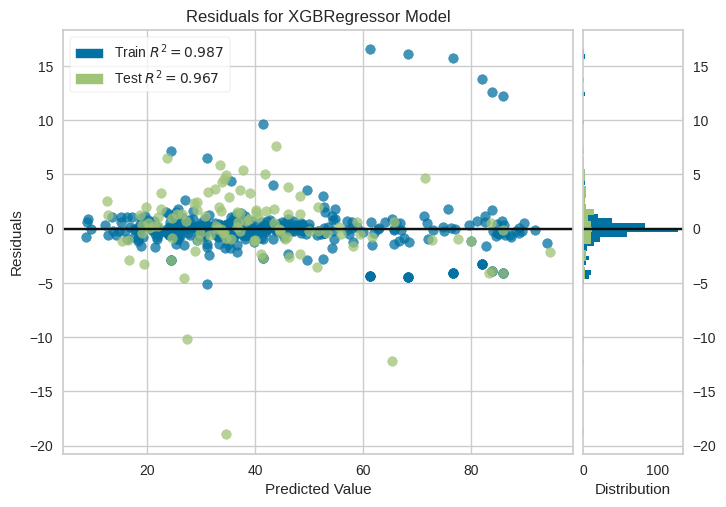

<Figure size 4000x2750 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pyswarm import pso
import matplotlib.pyplot as plt
from yellowbrick.regressor import ResidualsPlot
import xgboost as xgb

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ML works/dataset recycled aggregate natural fiber.csv')

# Check the initial size of the dataset
print("Initial dataset size:", df.shape)

# Clean the data by dropping rows with NaN values
df_clean = df.dropna()

# Check the size of the dataset after dropping NaN values
print("Dataset size after dropping NaN values:", df_clean.shape)

# Alternatively, fill NaN values with column means
# df_clean = df.fillna(df.mean())

# Select features and target, including the 'Fiber Type' feature
X = df_clean[['Cem', 'W/B', 'FA', 'CA',
                  'RCA', 'SCM', 'SP', 'NF',
                  'FT', 'Length', 'Age']]
y = df_clean['CS']

# One-hot encode the 'Fiber Type' feature
X = pd.get_dummies(X, columns=['FT'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for PSO
def objective_function(params):
    n_estimators, max_depth, learning_rate = params
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    learning_rate = float(learning_rate)

    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -r2_score(y_test, y_pred)  # negative because PSO minimizes the function

# Define the bounds for the hyperparameters
bounds = [(10, 500), (1, 50), (0.01, 0.3)]

# Perform PSO to find the best hyperparameters
best_params, _ = pso(objective_function, lb=[b[0] for b in bounds], ub=[b[1] for b in bounds], swarmsize=50, maxiter=50)

# Train the XGBoost model with the optimized hyperparameters
best_n_estimators = int(best_params[0])
best_max_depth = int(best_params[1])
best_learning_rate = float(best_params[2])
model = xgb.XGBRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, learning_rate=best_learning_rate, random_state=42)
model.fit(X_train, y_train)

# Predict the compressive strength
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the R^2 value
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R^2 value (Train): {r2_train}')
print(f'R^2 value (Test): {r2_test}')
print(f'n estimator: {best_n_estimators}')
print(f'Max depth: {best_max_depth}')
print(f'Learning rate: {best_learning_rate}')
# Visualize residuals
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
plt.figure(dpi=500)
visualizer.show()

# Prepare data for CSV output with data points
train_data = pd.DataFrame({
    'Data Points (Train)': range(len(y_train)),
    'Observed (Train)': y_train.values,
    'Predicted (Train)': y_train_pred,
    'Error (Train)': y_train.values - y_train_pred
})

test_data = pd.DataFrame({
    'Data Points (Test)': range(len(y_test)),
    'Observed (Test)': y_test.values,
    'Predicted (Test)': y_test_pred,
    'Error (Test)': y_test.values - y_test_pred
})

# Save to CSV
train_data.to_csv('train_predictions_xgb.csv', index=False)
test_data.to_csv('test_predictions_xgb.csv', index=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

# Mean Absolute Error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Absolute Error (Train): {mae_train}")
print(f"Mean Absolute Error (Test): {mae_test}")

# Mean Squared Error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (Train): {mse_train}")
print(f"Mean Squared Error (Test): {mse_test}")

# Root Mean Squared Error
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print(f"Root Mean Squared Error (Train): {rmse_train}")
print(f"Root Mean Squared Error (Test): {rmse_test}")

# Explained Variance Score (which is equivalent to R^2 Score here)
explained_variance_train = explained_variance_score(y_train, y_train_pred)
explained_variance_test = explained_variance_score(y_test, y_test_pred)
print(f"R^2 Score: {explained_variance_train}")
print(f"R^2 Score: {explained_variance_test}")

Mean Absolute Error (Train): 1.0242470100327787
Mean Absolute Error (Test): 2.1383914021714827
Mean Squared Error (Train): 5.054107035245506
Mean Squared Error (Test): 11.36792578128613
Root Mean Squared Error (Train): 2.2481341230552743
Root Mean Squared Error (Test): 3.371635475742615
R^2 Score: 0.9869102496196269
R^2 Score: 0.9672717796745487


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


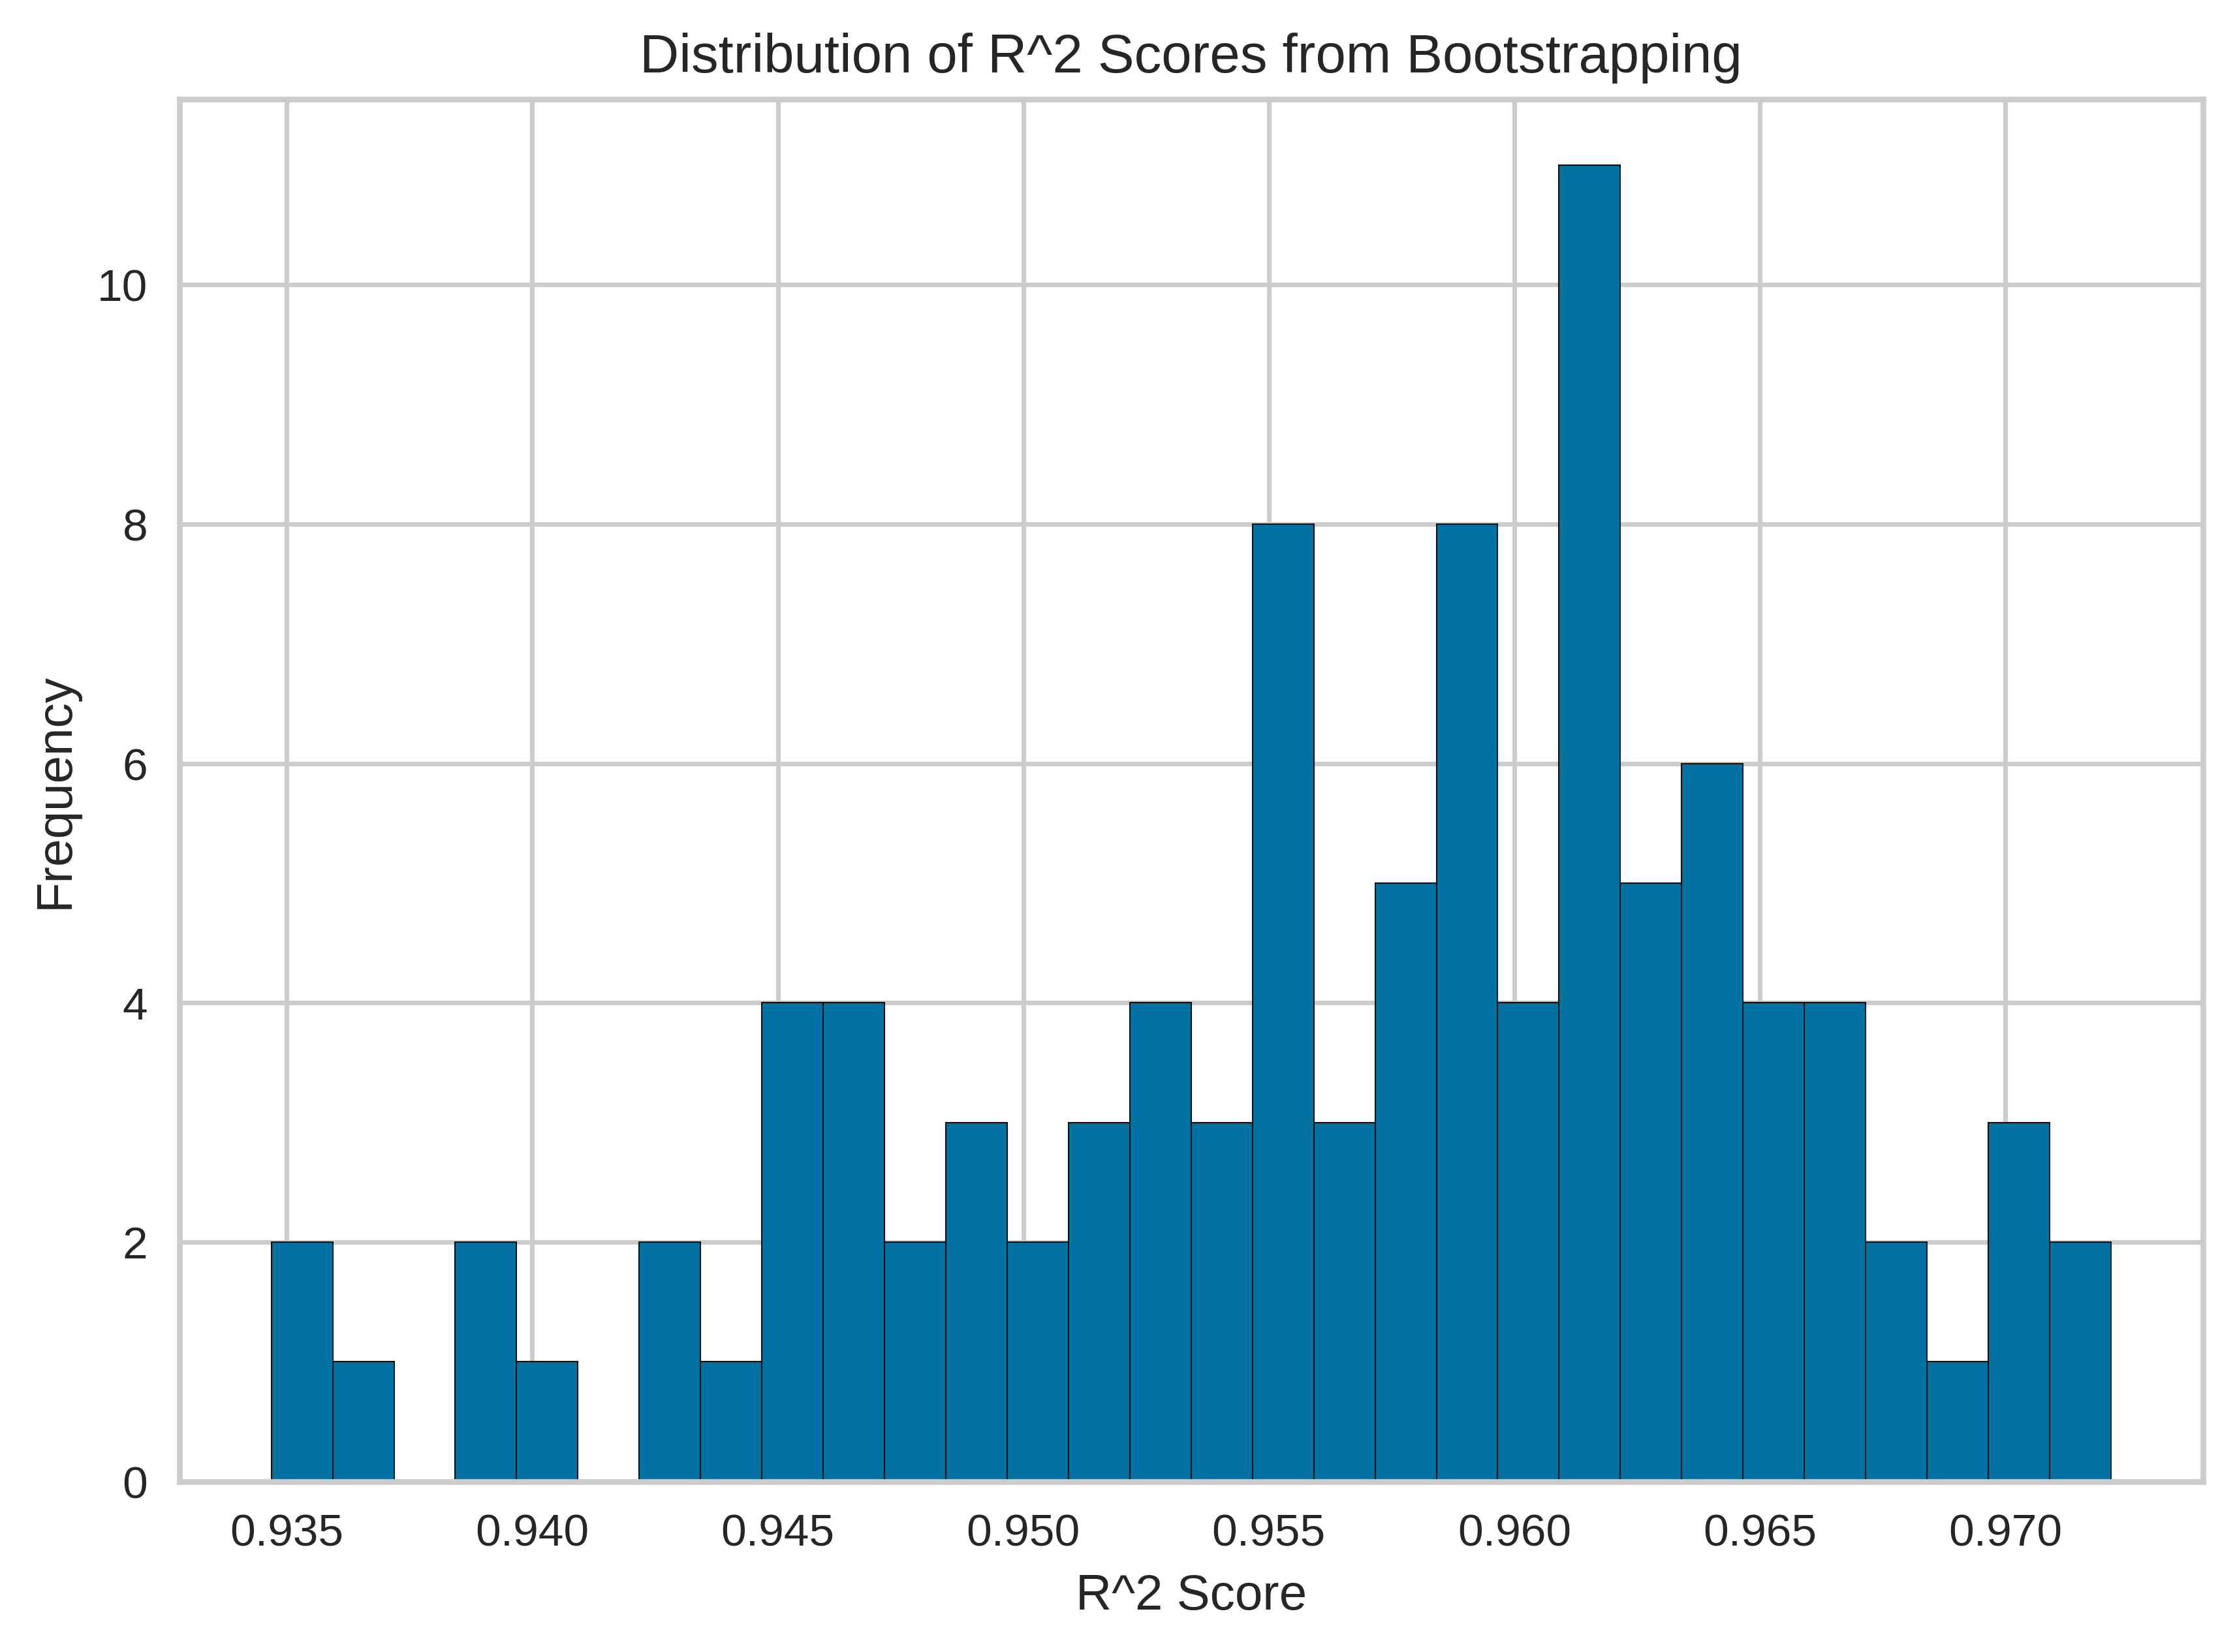

R^2 mean: 0.9567107713004275
R^2 standard deviation: 0.008513157377984824
R^2 95% confidence interval: (0.9400249828395773, 0.9733965597612777)
Uncertainty Percentage: 0.89%


In [ ]:
from sklearn.utils import resample
from tqdm import tqdm
# Uncertainty analysis using bootstrapping
n_iterations = 100  # Number of bootstrap iterations
r2_scores = []

for i in tqdm(range(n_iterations)):
    # Bootstrap sampling
    X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))

# Plot the distribution of R^2 scores
plt.figure(dpi=500)
plt.hist(r2_scores, bins=30, edgecolor='k')
plt.xlabel('R^2 Score')
plt.ylabel('Frequency')
plt.title('Distribution of R^2 Scores from Bootstrapping')
plt.show()

# Calculate the mean and confidence intervals
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
confidence_interval = (r2_mean - 1.96 * r2_std, r2_mean + 1.96 * r2_std)

# Calculate the uncertainty percentage
uncertainty_percentage = (r2_std / r2_mean) * 100

# Print the uncertainty values
print(f'R^2 mean: {r2_mean}')
print(f'R^2 standard deviation: {r2_std}')
print(f'R^2 95% confidence interval: {confidence_interval}')
print(f'Uncertainty Percentage: {uncertainty_percentage:.2f}%')